# AI KULLANARAK HİSSE SENEDİ DUYGU ANALİZİ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
import string
string.punctuation
nltk.download("stopwords")
stopwords.words('english')
nltk.download('punkt')

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
!pip install nltk
!pip install gensim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
stock_df = pd.read_csv("/content/stock_sentiment.csv")
stock_df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [ ]:
stock_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



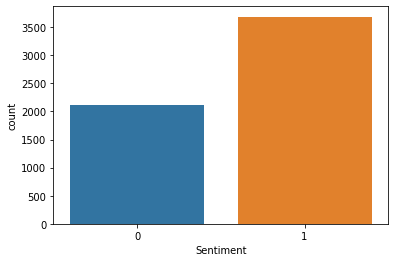

In [ ]:
sns.countplot(stock_df['Sentiment'])

In [ ]:
# Belirli bir sütundaki unique değerlerin sayısını bulduk.
stock_df['Sentiment'].nunique()

2

In [ ]:
Test = '$I love AI & Machine learning!!'
Test_punc_removed = [char for char in Test if char not in string.punctuation]
Test_punc_removed_join = ''.join(Test_punc_removed)
Test_punc_removed_join

'I love AI  Machine learning'

In [ ]:
# Dizeyi oluşturmak için karakterleri tekrar birleştirdik.
Test_punc_removed_join = ''.join(Test_punc_removed)
Test_punc_removed_join

'I love AI  Machine learning'

In [ ]:
# Noktalama işaretlerini kaldırmak için bir fonksiyon tanımladık.
def remove_punc(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)

    return Test_punc_removed_join

In [ ]:
# Veri kümemizden noktalama işaretlerini kaldırdık.
stock_df['Text Without Punctuation'] = stock_df['Text'].apply(remove_punc)
stock_df

,Text,Sentiment,Text Without Punctuation
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...


In [ ]:
stock_df['Text'][2]

"user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service"

In [ ]:
stock_df['Text Without Punctuation'][2]

'user Id be afraid to short AMZN  they are looking like a nearmonopoly in eBooks and infrastructureasaservice'

In [ ]:
# nltk'den ek stopwords edindik.
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year', 'https','alone','mho',
 'tsm','scty',
 'ost','bcei','gme', 'bks', 'vng', 'sne', 'fs','ng','rd','hn','wa','like','pm','imho','vng','nhod', 'ost','ng','oig',
 'bji','bji', 'ac', 'dont', 'do', 'he','she','it','im','is','are','zcs','esd','esf','ncle', 'qe','nqf','cwst',
 'cee','kcg', 'vng', 'vs', 'ng', 'don','gme','liked','wynn','iv','esf','hod','ddd','cee','sqnm', 'nx','vide','tit',
 'es','soq', 'pnk', 'cpw', 'bpz', 'aj','oi','int','chk','boc','mmy','bmc','bib','ong','tcx', 'fcx','shall','we',
 'sons','bin', 'gm', 'fio', 'ponw', 'jcp','yep','mnst','must','musnt','isnt','arent','syk','ng','oc', 'pnf','wont','kcg',
 'sqnm','float', 'short', 'vs', 'comin', 'ei','boc','chdn','vxy','wpi','nfp','tt','ist','gs','for', 'dot','coh','bwd',
 'nx','dt', 'znf', 'ko', 'cnx', 'idcc','sma','jpm','ko','eog','eps','feb','th','phm','ao', 'coh','bwd','dt',
 'yep','wtw', 'shd', 'esf', 'by', 'yr','sk','ttm','oct','ovti','yay','oa','aa','ess','tho', 'eay','jpm','at',
 'maybe','et', 'al', 'wo', 'dc', 'ath','fnf','nke','msft','ongs','spx','qqq','vcs','ognx','ppc', 'exp','onty','bmn',
 'vrng','fs', 'wk', 'chmt', 'fbc', 'isi','oig','got','pfe','ax','mt','dndn','apc','jon','th', 'esf','spx','dec',
 'asked','mho', 'tsm', 'ipgp', 'bc', 'bdc','ash','ddd','idcc','mnta'
 'judge', 'oex','mca','ema', 'ask', 'ive', 'pos', 'neg','fof','fol','oas','add','obv','lol','pxd','ave','fb', 'nfx','di','ok',
 'xe','gdp', 'icahn', 'ago', 'mas', 'mos','va','pop','gdp','jar','ces','fb','mocd','pi','bbby', 'big','jon','cm',
 'agnx','cm','vmw', 'ads', 'long', 'olon', 'pre','hm','hmm','hmmm','hmmmm','wow','tv','oex','tom','til', 'intc','cvi','setp',
 'tv','sbx','for', 'intc', 'nkd', 'vome', 'biof','athx','line','ch','etfc','biib','maykilijit','tgt','httpstco','let','hpq','st','dip','bit','cf','goes','si',
 'vbd','amid','ssy','ook','cs','fllow','bet','rt','imo','dip','let','gmx','era','famc','xxia','ooking',
 'xide',
 'aig',
 'nice',
 'bull',
 'angi',
 'fio',
 'panw',
 'jcp',
 'yep',
 'mnst',
 'gpn',
 'bac',
 'ipgp',
 'eqix',
 'bc',
 'bdc',
 'ash',
 'ddd',
 'idcc', 'could', 'elsewhere', 'down', 'cannot', 'doing', 'afterwards', 'take', 'most', 'should', 'as', 'although', 'done', 'however', 'for', 'own', 'nobody', 'mostly', 'a', 'thence', 'herein', 'i', 'at', 'beyond', 'call', 'hence', 'his', 'ours', 'serious', 'due', 'front', 'besides', 'so', 'unless', '’m', 'mine', 'together', 'himself', 'why', 'or', 'between', 'various', 'had', 'anyway', 'except', 'whenever', 'otherwise', 'can', 'him', 'you', 'ourselves', '’re', 'still', 'top', 'myself', 'become', "'s", 'quite', 'to', 'within', 'an', 'the', 'each', 'not', 'into', 'much', 'though', 'move', 'even', 'twenty', 'here', 'with', 'whole', '’s', 'moreover', 'nine', 'used', 'five', 'of', 'always', 'less', 'noone', 'then', 'becomes', 'its', 'such', 'n‘t', '‘ll', 'sometime', 'three', 'nowhere', 'amount', 'ten', 'others', 'towards', 'latterly', 'might', 'since', '‘s', 'your', 'may', 'formerly', 'already', 'made', '‘re', 'never', 'toward', 'namely', 'he', 'without', 'many', '‘ve', 'same', 'using', 'becoming', 'in', 'therefore', 'more', 'whither', 'give', 'else', 'if', 'against', 'very', 'must', 'anything', 'now', 'twelve', 'thereafter', 'any', 'latter', 'ever', 'they', 'forty', 'this', 'someone', 'everywhere', 'therein', 'whoever', 'us', 'off', 'throughout', 'than', 'enough', 'no', 'several', 'either', 'these', 'whereby', 'whom', 'few', 'make', 'me', '’ve', 'sometimes', 'anywhere', 'but', 'has', 'every', 'really', 'wherein', 'under', 'both', 'became', 'up', 'via', 'everyone', 'whether', 'thereby', 'where', 'thus', 'side', 'her', 'name', 'just', 'meanwhile', 'we', 'yours', 'first', 'last', 'wherever', 'how', 'which', 'hundred', 'beside', 'beforehand', "n't", "'ll", 'neither', 'whose', 'yourselves', 'go', '‘d', 'those', 'often', 'regarding', 'it', 'would', 'eight', 'whereafter', 'seem', 'fifty', 'whence', 'their', 'among', 'did', '‘m', 'former', 'get', 'hereafter', 'hers', "'ve", 'on', 'through', 'perhaps', 'does', 'after', "'d", 'next', 'while', 'yet', 'have', 'only', 'them', '’d', 'anyhow', 'rather', 'indeed', 'other', 'empty', "'m", 'show', 'she', 'nevertheless', 'two', "'re", 'by', 'all', 'from', 'when', 'who', 'across', 'further', 'during', 'our', 'before', 'that', 'is', 'please', 'too', 'none', 'above', 'bottom', 'least', 'four', 'thereupon', 'six', 'out', 'be', 'per', 'upon', 'will', 'do', 'something', 'whereupon', 'and', 'say', 'themselves', 'about', 'seeming', 'hereupon', '’ll', 'below', 'are', 'eleven', 'hereby', 'put', 'nor', 'herself', 'back', 'around', 'itself', 'sixty', 'what', 'my', 'over', 'until', 'been', 'behind', 'thru', 'once', 'see', 'some', 'somehow', 'fifteen', 'full', 'anyone', 'n’t', 'seems', 'part', 'whatever', 'being', 'one', 'because', 'was', 'seemed', 'another', 'nothing', 'everything', 'somewhere', 'were', 'onto', 'yourself', 're', 'am', 'there', 'keep', 'along', 'ca', 'also', 'again', 'well', 'amongst', 'almost', 'whereas', 'third'])

In [ ]:
# Stopwordsleri ve 2 karakterden az kısa kelimeleri kaldırdık.
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 3 and token not in stop_words:
            result.append(token)
            
    return result

In [ ]:
# metin sütununa ön işleme uyguladık.
stock_df['Text Without Punc & Stopwords'] = stock_df['Text Without Punctuation'].apply(preprocess)

In [ ]:
stock_df['Text'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts'

In [ ]:
stock_df['Text Without Punc & Stopwords'][0]

['kickers', 'watchlist', 'trade', 'method', 'method', 'prev', 'posts']

In [ ]:
# Stopwordsleri ve 2 veya daha az karakter içeren kelimeleri kaldırdık
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >= 2 and token not in stop_words:
            result.append(token)
            
    return result

In [ ]:
# metin sütununa ön işleme uyguladık.
stock_df['Text Without Punc & Stopwords'] = stock_df['Text Without Punctuation'].apply(preprocess)

In [ ]:
stock_df['Text'][3]

'MNTA Over 12.00  '

In [ ]:
stock_df['Text Without Punc & Stopwords'][3]

['mnta']

In [ ]:
# PLOT WORDCLOUD

# kelimeleri bir stringde birleştirdik
stock_df['Text Without Punc & Stopwords Joined'] = stock_df['Text Without Punc & Stopwords'].apply(lambda x: " ".join(x))

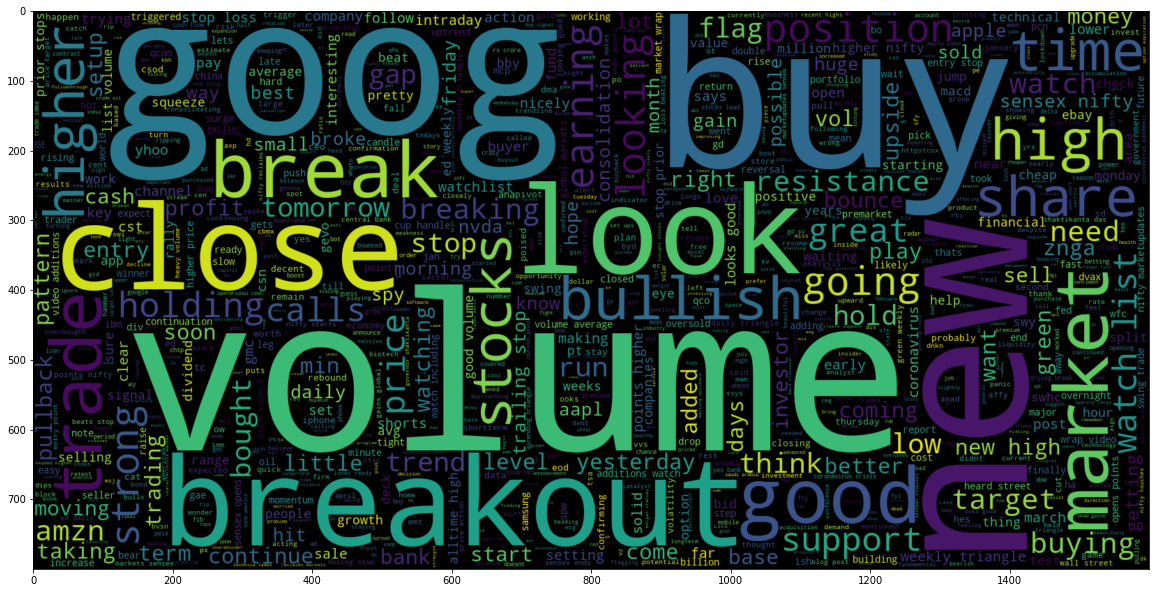

In [ ]:
# olumlu duyguya sahip metin için wordcloudu çizdik
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(stock_df[stock_df['Sentiment'] == 1]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

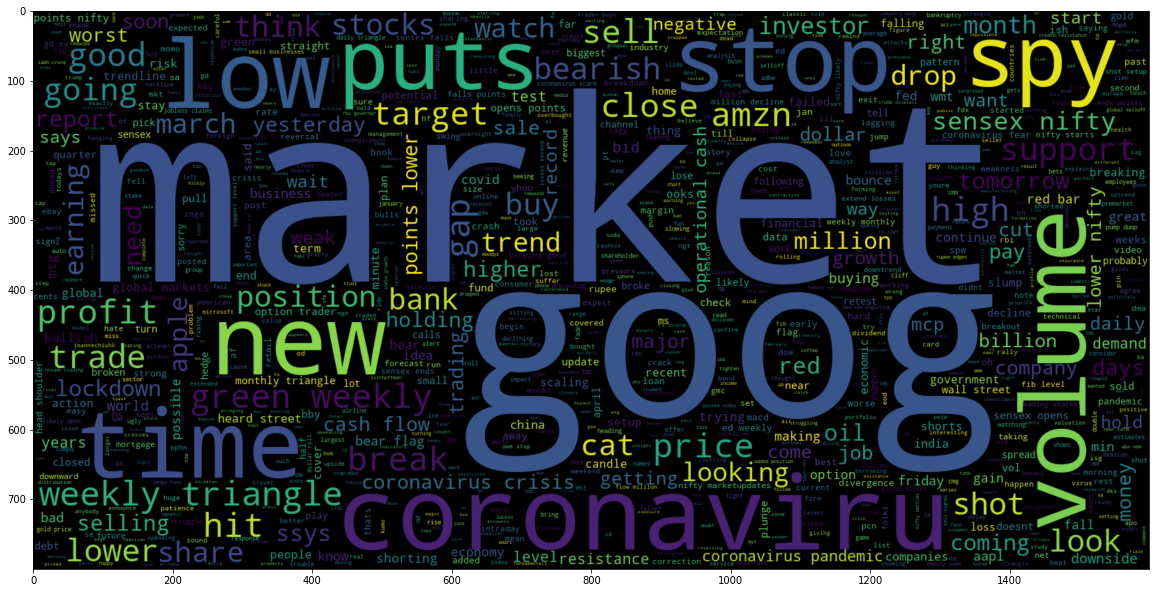

In [ ]:
# negatif olan metin için wordcloudu çizdik
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000, width = 1600, height = 800 ).generate(" ".join(stock_df[stock_df['Sentiment'] == 0]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

In [ ]:
# word_tokenize, bir stringi kelimelere bölmek için kullanılır
print(stock_df['Text Without Punc & Stopwords Joined'][0])
print(nltk.word_tokenize(stock_df['Text Without Punc & Stopwords Joined'][0]))

kickers watchlist trade method method prev posts
['kickers', 'watchlist', 'trade', 'method', 'method', 'prev', 'posts']


In [ ]:
# Belgedeki maksimum veri uzunluğunu elde ettik
# Bu daha sonra word embeddings oluşturulduğunda kullanılacaktır.
maxlen = -1
for doc in stock_df['Text Without Punc & Stopwords Joined']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 22


In [ ]:
tweets_length = [ len(nltk.word_tokenize(x)) for x in stock_df['Text Without Punc & Stopwords Joined'] ]
tweets_length

[7,
 6,
 6,
 1,
 0,
 1,
 7,
 9,
 7,
 3,
 6,
 10,
 8,
 7,
 8,
 6,
 9,
 7,
 10,
 2,
 3,
 3,
 1,
 3,
 1,
 9,
 3,
 3,
 7,
 4,
 5,
 4,
 6,
 2,
 7,
 7,
 3,
 7,
 7,
 9,
 8,
 3,
 7,
 4,
 2,
 8,
 7,
 3,
 7,
 7,
 7,
 9,
 6,
 1,
 7,
 11,
 7,
 8,
 1,
 9,
 7,
 10,
 1,
 8,
 6,
 6,
 5,
 3,
 4,
 5,
 8,
 3,
 5,
 12,
 4,
 4,
 6,
 5,
 2,
 8,
 5,
 2,
 7,
 7,
 8,
 2,
 5,
 4,
 6,
 2,
 0,
 4,
 7,
 1,
 6,
 5,
 5,
 6,
 1,
 2,
 5,
 2,
 11,
 5,
 6,
 8,
 13,
 4,
 6,
 9,
 9,
 7,
 2,
 3,
 7,
 9,
 7,
 5,
 7,
 3,
 3,
 3,
 9,
 4,
 1,
 3,
 7,
 11,
 6,
 7,
 2,
 0,
 0,
 2,
 5,
 10,
 7,
 5,
 6,
 7,
 5,
 8,
 10,
 3,
 5,
 7,
 10,
 5,
 4,
 8,
 7,
 1,
 7,
 7,
 10,
 10,
 6,
 5,
 4,
 3,
 3,
 5,
 2,
 3,
 9,
 4,
 5,
 9,
 5,
 12,
 7,
 4,
 5,
 9,
 8,
 7,
 4,
 2,
 7,
 9,
 7,
 10,
 4,
 7,
 3,
 3,
 5,
 3,
 7,
 7,
 3,
 5,
 4,
 3,
 3,
 7,
 9,
 7,
 7,
 7,
 9,
 8,
 7,
 12,
 8,
 5,
 5,
 2,
 8,
 10,
 7,
 8,
 8,
 7,
 8,
 4,
 5,
 5,
 10,
 7,
 3,
 3,
 2,
 8,
 2,
 9,
 7,
 13,
 8,
 7,
 10,
 4,
 7,
 2,
 2,
 12,
 12,
 5,
 6,
 8,
 12,
 5,
 2,
 2,
 

In [ ]:
# Bir metindeki kelime sayısı dağılımını çizdik
fig = px.histogram(x = tweets_length, nbins = 50)
fig.show()

In [ ]:
# Veri setinde bulunan toplam kelimeleri elde ettik
list_of_words = []
for i in stock_df['Text Without Punc & Stopwords']:
    for j in i:
        list_of_words.append(j)
list_of_words

['kickers',
 'watchlist',
 'trade',
 'method',
 'method',
 'prev',
 'posts',
 'movie',
 'return',
 'feageed',
 'indicator',
 'trades',
 'awesome',
 'id',
 'afraid',
 'amzn',
 'looking',
 'nearmonopoly',
 'ebooks',
 'mnta',
 'pgnx',
 'current',
 'downtrend',
 'break',
 'shortterm',
 'correction',
 'medterm',
 'downtrend',
 'mondays',
 'relative',
 'weakness',
 'nyx',
 'win',
 'tie',
 'tap',
 'ice',
 'aon',
 'goog',
 'ower',
 'trend',
 'channel',
 'test',
 'volume',
 'support',
 'watch',
 'tomorrow',
 'entry',
 'assuming',
 'opens',
 'tomorrow',
 'trigger',
 'buy',
 'setup',
 'worries',
 'expects',
 'market',
 'rally',
 'nowusually',
 'exact',
 'opposite',
 'happens',
 'time',
 'soon',
 'gamcos',
 'arry',
 'haverty',
 'apple',
 'extremely',
 'cheap',
 'great',
 'video',
 'maykiljil',
 'posted',
 'agree',
 'going',
 'higher',
 'possibly',
 'north',
 'momentum',
 'coming',
 'broke',
 'resistance',
 'solid',
 'volume',
 'friday',
 'setup',
 'ha',
 'hitting',
 'means',
 'resume',
 'targeting

In [ ]:
# Toplam unique kelime sayısını elde ettik
total_words = len(list(set(list_of_words)))
total_words

9257

In [ ]:
# verileri test ve eğitim olarak ayırdık 
X = stock_df['Text Without Punc & Stopwords']
y = stock_df['Sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [ ]:
X_train.shape

(5211,)

In [ ]:
X_test.shape

(580,)

In [ ]:
X_train

5095    [citing, improved, moneymarket, conditions, ba...
317     [shorts, paranoid, close, buyout, come, night,...
1243                  [aapl, learning, experience, study]
1446                       [wac, near, dma, great, group]
1567                      [positions, ana, hes, imm, wcx]
                              ...                        
2062                               [med, volume, picking]
581     [compq, gd, sv, characteristics, successful, t...
4890    [youre, going, tradable, bounce, heels, posttr...
4678    [watch, selling, volume, picking, moving, aver...
3669                                                [aee]
Name: Text Without Punc & Stopwords, Length: 5211, dtype: object

In [ ]:
# Sözcükleri tokenize etmek ve sequence sözcük dizileri oluşturmak için bir tokenizer oluşturduk
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

# Training 
train_sequences = tokenizer.texts_to_sequences(X_train)

# Testing 
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
train_sequences

[[2379, 3538, 3539, 1424, 70, 243, 71, 1783, 738, 2380, 3540, 3541, 3542],
 [148, 2381, 16, 664, 92, 457, 113, 3, 32, 3543, 3544, 1425],
 [113, 3545, 2382, 739],
 [2383, 108, 300, 48, 421],
 [301, 338, 491, 361, 1426],
 [1427,
  986,
  244,
  1183,
  1784,
  1184,
  865,
  2384,
  3546,
  3547,
  3548,
  1185,
  2385,
  317,
  665,
  3549],
 [109, 339],
 [1785, 23, 362, 1428, 1428, 152, 88, 987, 131],
 [3550, 1429, 132, 2386, 3551, 422, 423, 363],
 [181, 2387, 260, 39, 584, 585],
 [866, 318, 153, 1, 988, 220, 867],
 [2388, 2389, 49],
 [2390, 182],
 [3552, 49, 3553, 1430, 114, 60, 2391, 586, 3554],
 [3555, 261],
 [666, 1786, 1186, 1431],
 [30, 55, 13, 3556],
 [667, 190, 1787, 1788, 989, 364, 3557, 3558, 1789],
 [2, 12, 8, 1790, 61, 868, 42, 167, 20, 61],
 [1791, 587, 234, 365, 3559],
 [740, 2, 741, 66, 36, 61, 1187, 668],
 [1432,
  3560,
  1433,
  137,
  245,
  53,
  1792,
  588,
  1434,
  3561,
  742,
  990,
  539,
  424,
  3562],
 [3563, 2392, 458, 3564],
 [1188, 669, 1189, 161, 286, 

In [ ]:
test_sequences

[[143, 40, 1284],
 [5, 52, 1084, 901, 1],
 [253, 41, 1692, 632, 451, 64],
 [813, 8630, 234, 7894, 5674, 160, 272, 54, 147, 159, 18, 6075],
 [269, 3, 31, 345, 44, 3480, 158, 82, 8056, 31, 423, 115],
 [2403, 3124, 1834, 7917, 3, 511, 1564],
 [402],
 [3],
 [11, 192, 25, 28, 15, 333, 108, 9, 651, 2025, 68, 33, 11, 15, 237],
 [162, 465, 6440, 726, 225, 628, 1980, 1241, 1227, 143, 5099, 1980, 2104],
 [32, 918, 467, 394, 305, 2943, 1737, 78, 1028],
 [2634, 99, 198, 147, 839, 39],
 [190, 95, 124, 191, 862],
 [4175, 107, 440, 1472, 349, 5795, 819],
 [190, 95, 1223, 547, 1349, 283, 482, 219],
 [2707],
 [272, 160, 1242, 813, 492, 510, 233, 90, 535, 1293, 1296, 194],
 [137, 71, 1061, 1665, 165, 8712],
 [2565, 110, 51],
 [109, 504, 1814, 87, 50],
 [700, 51, 56, 22, 62, 6],
 [4, 129, 148, 875],
 [5, 52, 311, 1, 1076, 6718, 1],
 [528],
 [545],
 [704, 577, 3285],
 [6534, 264, 6],
 [169, 5, 52, 1176, 1, 153],
 [30, 18, 193, 13, 7189, 77],
 [221, 8414, 880, 1652, 12],
 [1506, 1008, 17, 48, 4723],
 [1925

In [ ]:
print("The encoding for document\n", X_train[1:2],"\n is: ", train_sequences[1])

The encoding for document
 317    [shorts, paranoid, close, buyout, come, night,...
Name: Text Without Punc & Stopwords, dtype: object 
 is:  [148, 2381, 16, 664, 92, 457, 113, 3, 32, 3543, 3544, 1425]


In [ ]:
# Eğitim ve teste verierine dolgu ekle
padded_train = pad_sequences(train_sequences, maxlen = 29, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 29, truncating = 'post')

In [ ]:
for i, doc in enumerate(padded_train[:3]):
     print("The padded encoding for document:", i+1," is:", doc)

The padded encoding for document: 1  is: [2379 3538 3539 1424   70  243   71 1783  738 2380 3540 3541 3542    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 2  is: [ 148 2381   16  664   92  457  113    3   32 3543 3544 1425    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 3  is: [ 113 3545 2382  739    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [ ]:
# Verileri kategorik 2B verilere dönüştürdük
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [ ]:
y_train_cat.shape

(5211, 2)

In [ ]:
y_test_cat.shape

(580, 2)

In [ ]:
y_train_cat

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
# LSTM

# Sequential Model
model = Sequential()

# embedding layer
model.add(Embedding(total_words, output_dim = 512))

# Çift Yönlü RNN ve LSTM
model.add(LSTM(256))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         4739584   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 5,560,194
Trainable params: 5,560,194
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# modeli eğitme
model.fit(padded_train, y_train_cat, batch_size = 32, validation_split = 0.2, epochs = 10)

Epoch 1/10
131/131 [==============================] - 48s 345ms/step - loss: 0.6655 - acc: 0.6279 - val_loss: 0.6486 - val_acc: 0.6558
Epoch 2/10
131/131 [==============================] - 44s 337ms/step - loss: 0.6470 - acc: 0.6459 - val_loss: 0.5214 - val_acc: 0.7507
Epoch 3/10
131/131 [==============================] - 43s 331ms/step - loss: 0.4544 - acc: 0.8078 - val_loss: 0.5151 - val_acc: 0.7498
Epoch 4/10
131/131 [==============================] - 43s 332ms/step - loss: 0.2638 - acc: 0.9074 - val_loss: 0.6347 - val_acc: 0.7200
Epoch 5/10
131/131 [==============================] - 43s 330ms/step - loss: 0.1890 - acc: 0.9369 - val_loss: 0.9249 - val_acc: 0.7220
Epoch 6/10
131/131 [==============================] - 43s 328ms/step - loss: 0.1462 - acc: 0.9523 - val_loss: 0.7848 - val_acc: 0.7191
Epoch 7/10
131/131 [==============================] - 44s 333ms/step - loss: 0.0995 - acc: 0.9635 - val_loss: 0.9553 - val_acc: 0.7335
Epoch 8/10
131/131 [==============================] - 4

In [ ]:
# tahmin etmek
pred = model.predict(padded_test)
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [ ]:
# orijinal değerleri içeren liste
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [ ]:
# metin dataların doğruluk değeri
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, prediction)
accuracy

0.5827586206896552

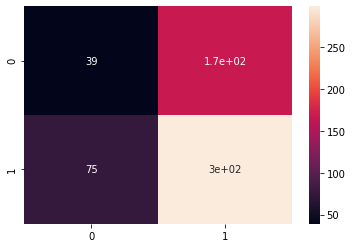

In [ ]:
# karmaşıklık matrisini çizmek
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)